Chọn dataset:
1. Zachary's Karate Club
2. Les Miserables Network
3. Florentine Families Network
Nhập lựa chọn (1-3): 2

=== Phân tích mạng ===
Số node: 77
Số cạnh: 254
Clustering trung bình: 0.573


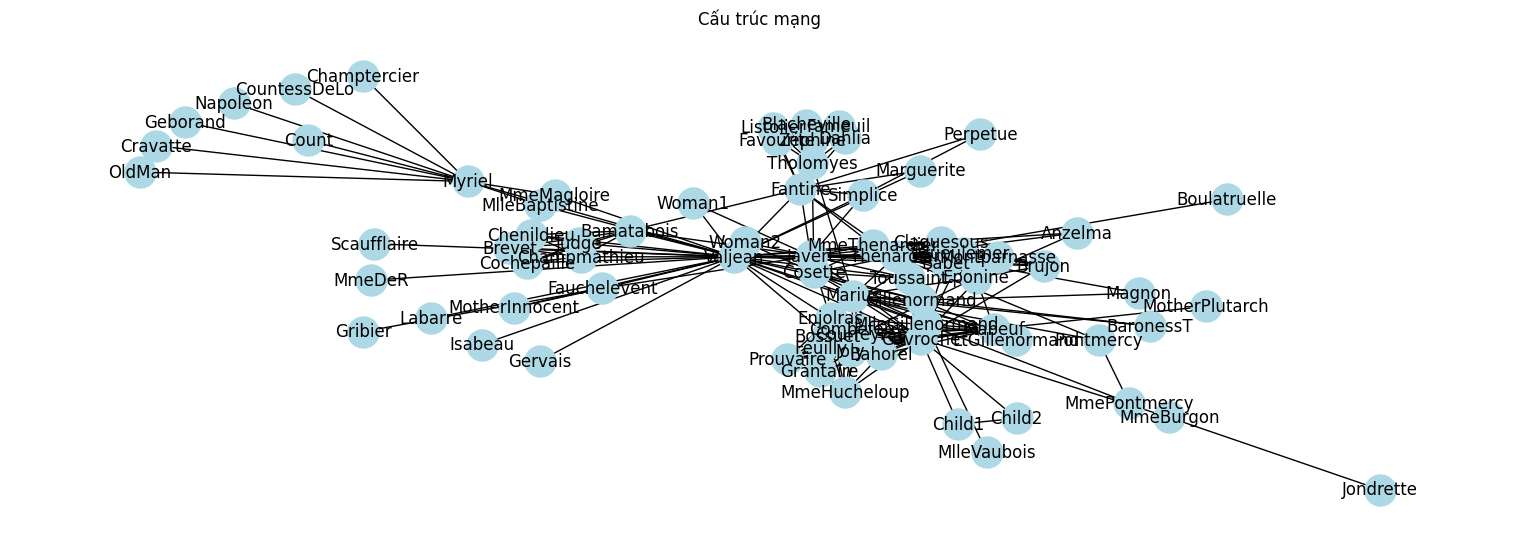

Train edges: 204
Test positive edges: 50
Test negative edges: 50

Bảng so sánh kết quả cho các phương pháp:
                    Method     AUC  Accuracy  Precision  Recall  F1-score
0         Common Neighbors  0.9430       0.8   0.734375    0.94  0.824561
1      Jaccard Coefficient  0.9038       0.8   0.734375    0.94  0.824561
2              Adamic-Adar  0.9476       0.8   0.734375    0.94  0.824561
3  Preferential Attachment  0.8188       0.5   0.500000    0.94  0.652778


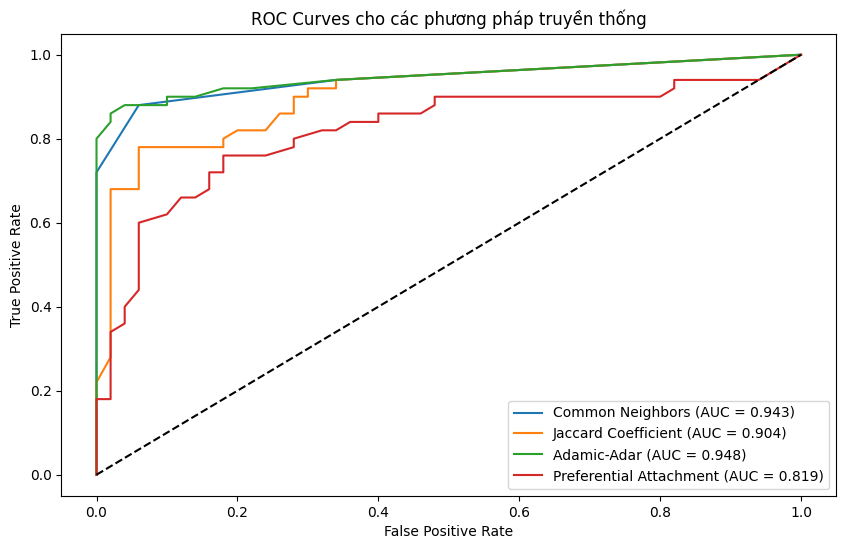


Kết quả AUC cho các phương pháp:
Common Neighbors: 0.943
Jaccard Coefficient: 0.904
Adamic-Adar: 0.948
Preferential Attachment: 0.819

Bảng kết quả mở rộng với Random Forest:
                    Method       AUC  Accuracy  Precision    Recall  F1-score
0         Common Neighbors  0.943000       0.8   0.734375  0.940000  0.824561
1      Jaccard Coefficient  0.903800       0.8   0.734375  0.940000  0.824561
2              Adamic-Adar  0.947600       0.8   0.734375  0.940000  0.824561
3  Preferential Attachment  0.818800       0.5   0.500000  0.940000  0.652778
4            Random Forest  0.986425       0.9   0.888889  0.941176  0.914286


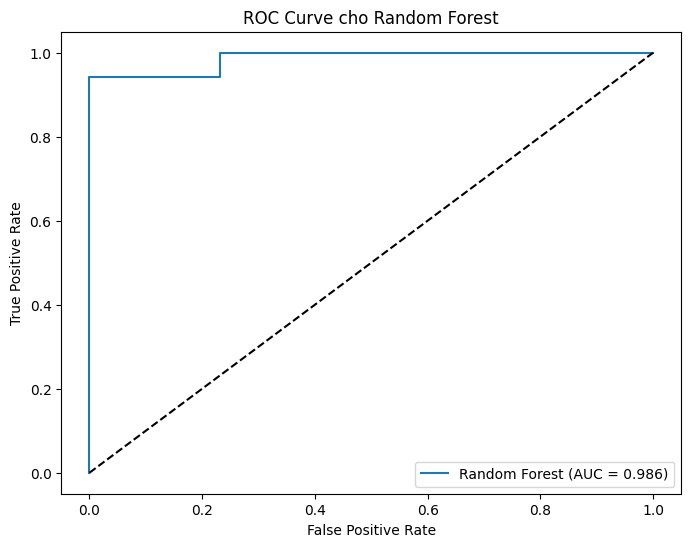

In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

class LinkPrediction:
    def __init__(self, dataset='karate'):
        """
        Khởi tạo với dataset đã cho.

        Parameters:
            dataset (str): Tên dataset ('karate', 'les', 'florentine')
        """
        if dataset == 'karate':
            self.G = nx.karate_club_graph()
        elif dataset == 'les':
            self.G = nx.les_miserables_graph()
        elif dataset == 'florentine':
            self.G = nx.florentine_families_graph()
        else:
            raise ValueError("Dataset không hợp lệ")

    def analyze_network(self):
        """Phân tích cơ bản về mạng."""
        print("\n=== Phân tích mạng ===")
        print(f"Số node: {self.G.number_of_nodes()}")
        print(f"Số cạnh: {self.G.number_of_edges()}")
        print(f"Clustering trung bình: {nx.average_clustering(self.G):.3f}")

        plt.figure(figsize=(15, 5))
        pos = nx.spring_layout(self.G, seed=42)
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', node_size=500)
        plt.title("Cấu trúc mạng")
        plt.show()

    def prepare_data(self):
        """Chuẩn bị dữ liệu train và test."""
        edges = list(self.G.edges())
        np.random.seed(42)
        np.random.shuffle(edges)

        n_test = int(len(edges) * 0.2)
        self.test_edges = edges[:n_test]
        self.train_edges = edges[n_test:]

        self.train_G = self.G.copy()
        self.train_G.remove_edges_from(self.test_edges)

        non_edges = list(nx.non_edges(self.train_G))
        np.random.shuffle(non_edges)
        self.test_non_edges = non_edges[:n_test]
        print(f"Train edges: {len(self.train_edges)}")
        print(f"Test positive edges: {len(self.test_edges)}")
        print(f"Test negative edges: {len(self.test_non_edges)}")

    def extract_features(self, G, u, v):
        """Trích xuất features cho các node pairs."""
        cn = len(list(nx.common_neighbors(G, u, v)))
        jc = list(nx.jaccard_coefficient(G, [(u, v)]))[0][2]
        aa = list(nx.adamic_adar_index(G, [(u, v)]))[0][2]
        pa = list(nx.preferential_attachment(G, [(u, v)]))[0][2]
        return [cn, jc, aa, pa]

    def prepare_ml_data(self, G, positive_edges, negative_edges):
        """Tạo dữ liệu cho machine learning."""
        X = [self.extract_features(G, u, v) for u, v in positive_edges + negative_edges]
        y = [1] * len(positive_edges) + [0] * len(negative_edges)
        return np.array(X), np.array(y)

    def evaluate_ml(self):
        """Huấn luyện mô hình ML và đánh giá."""
        X, y = self.prepare_ml_data(self.train_G, self.test_edges, self.test_non_edges)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

        # Tính các metric
        auc = roc_auc_score(y_test, y_pred_proba)
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Tạo DataFrame mới cho Random Forest
        rf_results = pd.DataFrame([{
            "Method": "Random Forest",
            "AUC": auc,
            "Accuracy": acc,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1
        }])

        # Concatenate với kết quả cũ
        self.results_df = pd.concat([self.results_df, rf_results], ignore_index=True)

        # Hiển thị bảng kết quả
        print("\nBảng kết quả mở rộng với Random Forest:")
        print(self.results_df)

        # Vẽ ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc:.3f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve cho Random Forest')
        plt.legend()
        plt.show()


    def evaluate_baselines(self):
        """Đánh giá các phương pháp truyền thống."""
        methods = {
            'Common Neighbors': lambda u, v: len(list(nx.common_neighbors(self.train_G, u, v))),
            'Jaccard Coefficient': lambda u, v: list(nx.jaccard_coefficient(self.train_G, [(u, v)]))[0][2],
            'Adamic-Adar': lambda u, v: list(nx.adamic_adar_index(self.train_G, [(u, v)]))[0][2],
            'Preferential Attachment': lambda u, v: list(nx.preferential_attachment(self.train_G, [(u, v)]))[0][2],
        }

        results = []

        for name, score_func in methods.items():
            # Tính điểm cho positive và negative edges
            pos_scores = [score_func(u, v) for u, v in self.test_edges]
            neg_scores = [score_func(u, v) for u, v in self.test_non_edges]

            # Tạo y_true và y_scores
            y_true = [1] * len(pos_scores) + [0] * len(neg_scores)
            y_scores = pos_scores + neg_scores
            y_pred = [1 if score > 0 else 0 for score in y_scores]  # Dự đoán nhị phân

            # Tính các metric
            auc = roc_auc_score(y_true, y_scores)
            acc = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred)
            recall = recall_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)

            # Lưu kết quả
            results.append({
                "Method": name,
                "AUC": auc,
                "Accuracy": acc,
                "Precision": precision,
                "Recall": recall,
                "F1-score": f1
            })

        # Chuyển kết quả thành DataFrame
        self.results_df = pd.DataFrame(results)
        print("\nBảng so sánh kết quả cho các phương pháp:")
        print(self.results_df)

        # Vẽ ROC Curves
        plt.figure(figsize=(10, 6))
        for name, score_func in methods.items():
            pos_scores = [score_func(u, v) for u, v in self.test_edges]
            neg_scores = [score_func(u, v) for u, v in self.test_non_edges]

            y_true = [1] * len(pos_scores) + [0] * len(neg_scores)
            y_scores = pos_scores + neg_scores
            fpr, tpr, _ = roc_curve(y_true, y_scores)

            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_true, y_scores):.3f})")

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves cho các phương pháp truyền thống')
        plt.legend()
        plt.show()

        print("\nKết quả AUC cho các phương pháp:")
        # Sử dụng results_df thay vì results để in kết quả AUC
        for _, row in self.results_df.iterrows():
            print(f"{row['Method']}: {row['AUC']:.3f}")

    def run_experiment(self):
        """Chạy thử nghiệm hoàn chỉnh."""
        self.analyze_network()
        self.prepare_data()
        self.evaluate_baselines()
        self.evaluate_ml()

if __name__ == "__main__":
    print("Chọn dataset:")
    print("1. Zachary's Karate Club")
    print("2. Les Miserables Network")
    print("3. Florentine Families Network")
    choice = input("Nhập lựa chọn (1-3): ")
    datasets = {'1': 'karate', '2': 'les', '3': 'florentine'}

    if choice in datasets:
        lp = LinkPrediction(dataset=datasets[choice])
        lp.run_experiment()
    else:
        print("Lựa chọn không hợp lệ!")


In [4]:
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.4 MB/s eta 0:00:00


Epoch 0, Loss: 1.2001219987869263
Epoch 10, Loss: 0.0464819110929966
Epoch 20, Loss: 0.013536332175135612
Epoch 30, Loss: 0.0044378009624779224
Epoch 40, Loss: 0.001761103281751275
Epoch 50, Loss: 0.0010839671595022082
Epoch 60, Loss: 0.0007782889879308641
Epoch 70, Loss: 0.0006266739801503718
Epoch 80, Loss: 0.000527162803336978
Epoch 90, Loss: 0.00045338363270275295


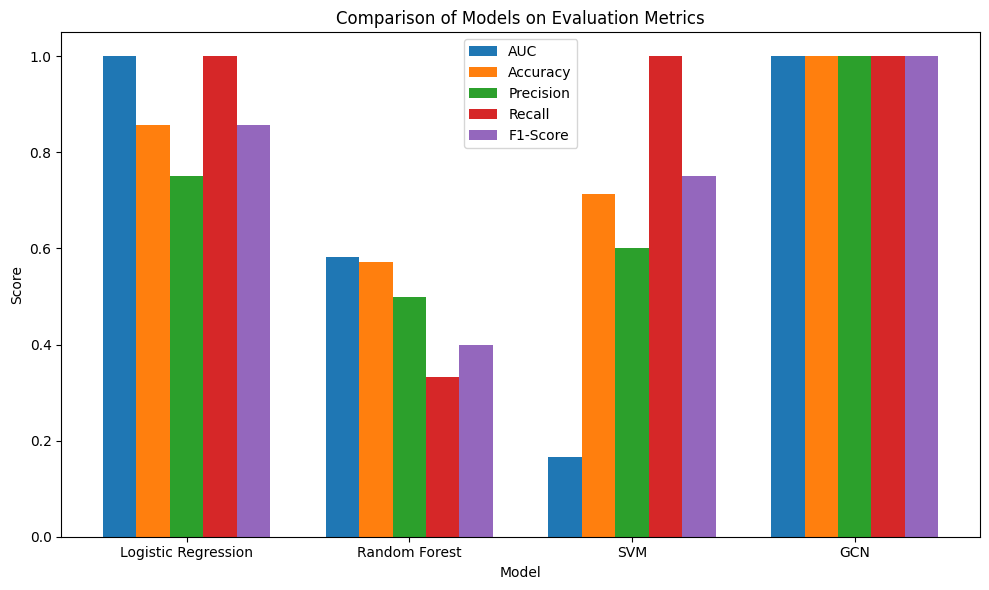

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import torch
import torch_geometric as tg
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split

# Load the Karate Club Graph
G = nx.karate_club_graph()

# Feature matrix (random features for the nodes)
node_features = np.random.randn(len(G.nodes), 64)  # 64-dimensional features for each node
node_labels = np.array([G.nodes[node]['club'] == 'Mr. Hi' for node in G.nodes])  # 0 for 'Officer', 1 for 'Mr. Hi'

# Convert to PyTorch tensors
node_features = torch.tensor(node_features, dtype=torch.float32)
node_labels = torch.tensor(node_labels, dtype=torch.long)

# Create edge list for GCN
edges = list(G.edges)
edge_index = torch.tensor([[u, v] for u, v in edges], dtype=torch.long).t().contiguous()

# Prepare train-test split
train_nodes, test_nodes = train_test_split(range(len(G.nodes)), test_size=0.2, random_state=42)

# GCN Model definition (same as before)
class GCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = tg.nn.GCNConv(input_dim, hidden_dim)
        self.conv2 = tg.nn.GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Train the GCN model
def train_gcn(model, features, edge_index, labels, train_nodes, epochs=100, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        out = model(features, edge_index)
        loss = criterion(out[train_nodes], labels[train_nodes])

        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluate the GCN model
def evaluate_gcn(model, features, edge_index, labels, test_nodes):
    model.eval()
    with torch.no_grad():
        out = model(features, edge_index)
        pred = out.argmax(dim=1)

    accuracy = accuracy_score(labels[test_nodes].numpy(), pred[test_nodes].numpy())
    precision = precision_score(labels[test_nodes].numpy(), pred[test_nodes].numpy())
    recall = recall_score(labels[test_nodes].numpy(), pred[test_nodes].numpy())
    f1 = f1_score(labels[test_nodes].numpy(), pred[test_nodes].numpy())
    auc = roc_auc_score(labels[test_nodes].numpy(), pred[test_nodes].numpy())

    return accuracy, precision, recall, f1, auc

# Logistic Regression
def train_logistic_regression(features, labels, train_nodes):
    model = LogisticRegression(max_iter=1000)
    model.fit(features[train_nodes], labels[train_nodes])
    return model

# Random Forest
def train_random_forest(features, labels, train_nodes):
    model = RandomForestClassifier(n_estimators=100)
    model.fit(features[train_nodes], labels[train_nodes])
    return model

# Support Vector Machine
def train_svm(features, labels, train_nodes):
    model = SVC(probability=True)
    model.fit(features[train_nodes], labels[train_nodes])
    return model

# Prepare model and train the GCN
gcn_model = GCNModel(input_dim=64, hidden_dim=64, output_dim=2)
train_gcn(gcn_model, node_features, edge_index, node_labels, train_nodes)

# Evaluate the GCN model
gcn_metrics = evaluate_gcn(gcn_model, node_features, edge_index, node_labels, test_nodes)

# Train other models
lr_model = train_logistic_regression(node_features.numpy(), node_labels.numpy(), train_nodes)
rf_model = train_random_forest(node_features.numpy(), node_labels.numpy(), train_nodes)
svm_model = train_svm(node_features.numpy(), node_labels.numpy(), train_nodes)

# Evaluate other models
lr_preds = lr_model.predict(node_features[test_nodes])
rf_preds = rf_model.predict(node_features[test_nodes])
svm_preds = svm_model.predict(node_features[test_nodes])

lr_auc = roc_auc_score(node_labels[test_nodes].numpy(), lr_model.predict_proba(node_features[test_nodes])[:, 1])
rf_auc = roc_auc_score(node_labels[test_nodes].numpy(), rf_model.predict_proba(node_features[test_nodes])[:, 1])
svm_auc = roc_auc_score(node_labels[test_nodes].numpy(), svm_model.predict_proba(node_features[test_nodes])[:, 1])

# Compute evaluation metrics for the models
lr_accuracy = accuracy_score(node_labels[test_nodes].numpy(), lr_preds)
rf_accuracy = accuracy_score(node_labels[test_nodes].numpy(), rf_preds)
svm_accuracy = accuracy_score(node_labels[test_nodes].numpy(), svm_preds)

lr_precision = precision_score(node_labels[test_nodes].numpy(), lr_preds)
rf_precision = precision_score(node_labels[test_nodes].numpy(), rf_preds)
svm_precision = precision_score(node_labels[test_nodes].numpy(), svm_preds)

lr_recall = recall_score(node_labels[test_nodes].numpy(), lr_preds)
rf_recall = recall_score(node_labels[test_nodes].numpy(), rf_preds)
svm_recall = recall_score(node_labels[test_nodes].numpy(), svm_preds)

lr_f1 = f1_score(node_labels[test_nodes].numpy(), lr_preds)
rf_f1 = f1_score(node_labels[test_nodes].numpy(), rf_preds)
svm_f1 = f1_score(node_labels[test_nodes].numpy(), svm_preds)

# Collect the results
model_results = {
    'Logistic Regression': {'AUC': lr_auc, 'Accuracy': lr_accuracy, 'Precision': lr_precision, 'Recall': lr_recall, 'F1-Score': lr_f1},
    'Random Forest': {'AUC': rf_auc, 'Accuracy': rf_accuracy, 'Precision': rf_precision, 'Recall': rf_recall, 'F1-Score': rf_f1},
    'SVM': {'AUC': svm_auc, 'Accuracy': svm_accuracy, 'Precision': svm_precision, 'Recall': svm_recall, 'F1-Score': svm_f1},
    'GCN': {'AUC': gcn_metrics[4], 'Accuracy': gcn_metrics[0], 'Precision': gcn_metrics[1], 'Recall': gcn_metrics[2], 'F1-Score': gcn_metrics[3]}
}

# Plot the results
labels = list(model_results.keys())
auc_scores = [model_results[model]['AUC'] for model in labels]
accuracy_scores = [model_results[model]['Accuracy'] for model in labels]
precision_scores = [model_results[model]['Precision'] for model in labels]
recall_scores = [model_results[model]['Recall'] for model in labels]
f1_scores = [model_results[model]['F1-Score'] for model in labels]

x = np.arange(len(labels))
width = 0.15

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - 2*width, auc_scores, width, label='AUC')
ax.bar(x - width, accuracy_scores, width, label='Accuracy')
ax.bar(x, precision_scores, width, label='Precision')
ax.bar(x + width, recall_scores, width, label='Recall')
ax.bar(x + 2*width, f1_scores, width, label='F1-Score')

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Comparison of Models on Evaluation Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()


Các chỉ số đánh giá đều đã cải thiện lên đáng kể so với khi sử dụng mô hình khác cải thiện đôi chút đối với Logistic Regression. Điều này cho thấy việc áp dụng GCN giúp mô hình cải thiện khả năng phân biệt các cạnh đúng và sai trong đồ thị. Các GCN có thể khai thác tốt hơn các thông tin cấu trúc và mối quan hệ giữa các node, từ đó cải thiện hiệu suất phân loại.